# Tutorial: Discrete Choice with Taste Shocks

1. Solve SIM model with labor force participation
2. Practice: add search frictions
3. Practice: explore effect of taste shock scale on block Jacobian

In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from copy import deepcopy
# import sequence_jacobian as sj

from sequence_jacobian import grids, interpolate
from sequence_jacobian.blocks.stage_block import StageBlock
from sequence_jacobian.blocks.support.stages import Continuous1D, ExogenousMaker, LogitChoice

## 1 SIM model with labor force participation

So far in this course, we used `HetBlock` to represent the SIM model in SSJ. `HetBlock` supports models with a sequence of discrete shocks (given by `exogenous` kwarg in constructor) followed by a continuous choice. `StageBlock` is a more flexible version of `HetBlock`, that allows for an arbitrary sequence of stages, including logit choice from a discrete choice set. Eventually, `StageBlock` may just supersede `HetBlock`, but it's still in an experimental stage, so we did not want to get rid of our trusty `HetBlock` yet.

### 1.1 Setup

Strictly-speaking, the state space in the beginning of period is $(z, a)$
<!-- - employment status $e \in \{E, N\}$ chosen by househod -->
- productivity $z \in \{z_1, \dots, z_{m}\} \equiv \mathcal{G}_z$
- liquid assets $a \in [\underline{a}, \infty)$

However, in stage 3, we'll want to solve for consumption and asset policies conditional on labor supply $n \in \{0, 1\}.$ The implementation of `StageBlock` does not allow for changing the number of axes between stages. So, we will define everything on the largest grid we need, i.e. $(n, z, a)$ for
- labor supply $n \in \{0, 1\}$

#### Stage 1: productivity shock

Labor productivity follows a discretized AR(1) process in logs
$$
\begin{align*}
\log z &= \rho_z \log z_{-} + \epsilon
\\
\epsilon &\sim \mathcal{N}(0, \sigma_z^2)
\end{align*}
$$

As always, we're going to discretize this using Rouwenhorst method. So, we'll end up with a finite grid $\mathcal{G_z} \equiv [z_1, \dots, z_m]$ and transition matrix $\Pi_z \in \mathbb{R}^{m\times m}$. Then, backward iteration amounts to
$$
V^{(1)} = \Pi_z V^{(2)}
$$
and forward iteration amount to
$$
D^{(2)} = \Pi_z' D^{(1)}
$$
**Exploiting sparsity**: shock is independent of all other states $(n, a)$.

Let's initialize this stage using the---somewhat awkwardly named---constructor `ExogenousMaker`. The inputs of this function are
- `markov_name`: name of Markov matrix that drives this state
- `index`: axis of corresponding state
- `name`: just a name for the stage (this is how we'll refer to stage-specific data later)

In [2]:
prod_stage = ExogenousMaker(markov_name='z_markov', index=1, name='prod')

#### Stage 2: Labor supply choice

Households decide whether to work full time or not at all. Working has a utility cost $\varphi.$ On the slides, I accounted for disutility of labor in the consumption-saving stage. Then, it affects this stage via next-period value function $V^{(3)}$. Alternatively, we can account for the cost here. Also, notice that "phantom state" $n_-$ that we need to span the third axis of the state space.
$$
V^{(2)}(n_{-}, z, a_-) = \max_{n \in \{0, 1\}} V^{(3)}(n, z, a_-) - \varphi n + \underbrace{\varepsilon(n)}_{\text{taste shock}}
$$
Solving this stage will yield us choice probabilities $P(n|n_-, z, a_-)$. This will be used in forward iteration
$$
D^{(3)}(n, \bullet) = \sum_{n_-} P(n|n_-, \bullet)D^{(2)}(n_-, \bullet)
$$

**Sparsity**: $P$ maps $(n_-, \bullet)$ into $n$ and not $(n, \bullet).$ 

We initialize the logit choice stage via the---aptly named---constructor `LogitChoice`. The inputs are
- `value`: name of value function, SSJ has to know which object to apply the logsum formula to
- `backward`: names of other variables that have to be propagated backward, typically this is partial value function needed for EGM in continuous choice stage 
- `index`: axis of correspoinding state
- `name`: name of stage
- `taste_shock_scale`: name of $\sigma_\varepsilon$ parameter, needed for all formulas
- `f`: (optional) function that implements additive utility cost on expanded state $(n| n_-, z, a_-)$. This is useful to implement costs that depend on origin as well as destination $(n|n_-)$. Setting some costs to infinity implements constraints on discrete choice (more on this below).

Let's start by implementing the cost function `util_l`.

In [3]:
def util_l(V, vphi):
    # on (n| n_)
    flow_u = np.array([[-vphi, -vphi],  # E|E and E|N
                       [0    , 0]])     # N|E and N|N

    # on (n| n_, z, a)
    shape = np.zeros((2, 2,) + V.shape[1:])
    flow_u = flow_u[..., np.newaxis, np.newaxis] + shape

    return flow_u

We're now ready to initialize the stage.

In [4]:
labsup_stage = LogitChoice(value='V', backward='Va', index=0, name='labsup',
                           taste_shock_scale='taste_shock', f=util_l)

#### Stage 3: Consumption-saving decision

The Bellman equation is
$$
\begin{align*}
V_t^{(3)}(n, z, a_{-}) = \max_{c, a} u(c) + \beta \mathbb{E}_tV_{t+1}^{(0)}(n, z, a)
\qquad
\text{s.t. } c + a &= (1 + r_t)a_{-} + w_t n_t z_t + T_t
\\
a &\geq \underline{a}
\end{align*}
$$

This is the most involved stage, as we have to implement EGM with upper envelope. To give you an idea of where we're going, we'll construct this stage with the constructor `Continuous1D`, whose inputs are almost the same as they are for a `HetBlock`:
```
consav_stage = Continuous1D(backward=['V', 'Va'], policy='a', f=dcegm, name='consav', hetoutputs=[labsup])
```
Inputs are
- `backward`: list of variables we need to propagate backward
- `policy`: name of endogenous state
- `f`: function that implements single step of backward iteration, $\left(V^{(j+1)}, V_a^{(j+1)}\right) \to \left(V^{(j)}, V_a^{(j)}\right)$
- `hetoutputs`: (optional) list of functions reporting policies on the grid that are not required to perform the backward iteration, these functions will be called only when the backward iteration has converged

Let's start building up the `dcegm` function.

In [5]:
def dcegm(V, Va, a_grid, coh, y, r, beta, eis):
    """DC-EGM algorithm"""
    # use all FOCs on endogenous grid
    W = beta * V                                                  # end-of-stage vfun
    uc_endo = beta * Va                                           # envelope condition
    c_endo = uc_endo** (-eis)                                     # Euler equation
    a_endo = (c_endo + a_grid - y[..., np.newaxis]) / (1 + r)     # budget constraint 

    # interpolate with upper envelope, enforce borrowing limit
    V, c, a = upperenv(W, a_endo, coh, a_grid, eis)

    # update Va on exogenous grid
    uc = c ** (-1 / eis)                                          # Euler equation
    Va = (1 + r) * uc                                             # envelope condition

    return V, Va, a, c

Everything that's new happens in `upperenv` function. This can be written in a fairly general way. First, let us use a simple wrapper to make it independent of the size of the state space. We temporarily collapse states associated with all other stages into a single axis. The real work is done by `upperenv_vec`. 

In [6]:
def upperenv(W, a_endo, coh, a_grid, *args):
    # collapse (n, z, a) into (b, a)
    shape = W.shape
    W = W.reshape((-1, shape[-1]))
    a_endo = a_endo.reshape((-1, shape[-1]))
    coh = coh.reshape((-1, shape[-1]))
    V, c, a = upperenv_vec(W, a_endo, coh, a_grid, *args)

    # report on (n, z, a)
    return V.reshape(shape), c.reshape(shape), a.reshape(shape)

We're finally ready to discuss the core upper envelope step. To gist is the following. We consider every segment of the endogenous grid $(a_{j}^{endo}, a_{j+1}^{endo})$ and find all the exogenous gridpoints $a^{grid}_i$ that fall into that segment. We interpolate there to get a candidate solution $a_i$. Since the endogenous grid is non-monotonic, the same point $a^{grid}_i$ may be bracketed by another segment $(a_{\tilde j}^{endo}, a_{\tilde j+1}^{endo}).$ When this happens, we keep the solution that gives higher value. 

In [7]:
@njit
def upperenv_vec(W, a_endo, coh, a_grid, *args):
    """Interpolate value function and consumption to exogenous grid."""
    n_b, n_a = W.shape
    a = np.zeros_like(W)
    c = np.zeros_like(W)
    V = -np.inf * np.ones_like(W)

    # loop over other states, collapsed into single axis
    for ib in range(n_b):
        # loop over segments of endogenous asset grid from EGM (not necessarily increasing)
        for ja in range(n_a - 1):
            a_low, a_high = a_endo[ib, ja], a_endo[ib, ja + 1]
            W_low, W_high = W[ib, ja], W[ib, ja + 1]
            ap_low, ap_high = a_grid[ja], a_grid[ja + 1]
            
           # loop over exogenous asset grid (increasing) 
            for ia in range(n_a):  
                acur = a_grid[ia]
                coh_cur = coh[ib, ia]
                
                interp = (a_low <= acur <= a_high) 
                extrap = (ja == n_a - 2) and (acur > a_endo[ib, n_a - 1])

                # exploit that a_grid is increasing
                if (a_high < acur < a_endo[ib, n_a - 1]):
                    break

                if interp or extrap:
                    W0 = interpolate.interpolate_point(acur, a_low, a_high, W_low, W_high)
                    a0 = interpolate.interpolate_point(acur, a_low, a_high, ap_low, ap_high)
                    c0 = coh_cur - a0
                    V0 = util_c(c0, *args) + W0

                    # upper envelope, update if new is better
                    if V0 > V[ib, ia]:
                        a[ib, ia] = a0 
                        c[ib, ia] = c0
                        V[ib, ia] = V0

        # Enforce borrowing constraint
        ia = 0
        while ia < n_a and a_grid[ia] <= a_endo[ib, 0]:
            a[ib, ia] = a_grid[0]
            c[ib, ia] = coh[ib, ia]
            V[ib, ia] = util_c(c[ib, ia], *args) + W[ib, 0]
            ia += 1

    return V, c, a

The `upperenv_vec` has to evaluate flow utility from consumption at interpolated points. Let's define `util_c` function that's njitted because it's called within an njitted function. 

In [8]:
@njit
def util_c(c, eis):
    if eis == 1:
        u = np.log(c)
    else:
        u = c ** (1 - 1 / eis) / (1 - 1 / eis)
    return u


def employment(c):
    l = np.zeros_like(c)
    l[0, ...] = 1
    return l

Lastly, let's report the mass of households that choose to work in a given period. This could be read off from the choice probabilities but it's more convenient to define it directly as a `hetoutput`, attached to the consav stage.  

Now, we have all the pieces to construct the consumption-savings stage.

In [9]:
consav_stage = Continuous1D(backward=['V', 'Va'], policy='a', f=dcegm,
                            name='consav', hetoutputs=[employment])

#### Put everything together

Let's stitch together the 3 stages to form the `StageBlock` representing this HA problem. As in the case of a `HetBlock`, we need also have to add 
- `backward_init`: function that constructs the initial guess for backward variables
- `hetinputs`: (optional) list of functions that map aggregate inputs from outside the block into multidimensional inputs

As usual, we compute the initial guess from an old Keynesian consumption function.

In [10]:
def hh_init(coh, a_grid, eis):
    V = util_c(0.2 * coh, eis) / 0.01
    Va = np.empty_like(V)
    Va[..., 1:-1] = (V[..., 2:] - V[..., :-2]) / (a_grid[2:] - a_grid[:-2])
    Va[..., 0] = (V[..., 1] - V[..., 0]) / (a_grid[1] - a_grid[0])
    Va[..., -1] = (V[..., -1] - V[..., -2]) / (a_grid[-1] - a_grid[-2])
    return V, Va 

Let's specify hetinputs.
- `make_grids`: construct Markov process for productivity and the assets grid 
- `labor_income`: combines grids with aggregate wage and interest rate to build income and cash on hand

**Comment:** Matt advocated for double exponential grid for assets in SIM model. Here, I don't want to bunch points as much near the borrowing constraint, because discrete choice creates nonlinearities away from the borrowing constraint as well. Our old `grids.agrid` function does single-exponential grid, which I will use here.

In [11]:
def make_grids(rho_z, sd_z, n_z, min_a, max_a, n_a):
    z_grid, z_dist, z_markov = grids.markov_rouwenhorst(rho_z, sd_z, n_z)
    a_grid = grids.agrid(max_a, n_a, min_a)
    return z_grid, z_dist, z_markov, a_grid


def labor_income(a_grid, z_grid, r, w):
    y = z_grid[np.newaxis, :] * np.array([w, 0.1])[:, np.newaxis]           # on (n, z)
    coh = (1 + r) * a_grid[np.newaxis, np.newaxis, :] + y[..., np.newaxis]  # on (n, z, a)
    return y, coh

At last, we assemble the `StageBlock`.

In [12]:
hh = StageBlock([prod_stage, labsup_stage, consav_stage], name='hh',
                backward_init=hh_init, hetinputs=[make_grids, labor_income])

print(hh)
print(f"Inputs: {hh.inputs}")
print(f"Outputs: {hh.outputs}")

<StageBlock 'hh' with stages ['prod', 'labsup', 'consav']>
Inputs: ['taste_shock', 'vphi', 'r', 'beta', 'eis', 'rho_z', 'sd_z', 'n_z', 'min_a', 'max_a', 'n_a', 'w']
Outputs: ['A', 'C', 'L']


## 2 Solving the baseline model

Consider 3 cases.
- `sim`: no disutility from labor implies that everybody works all the time
- `ck`: disutility of labor binds for non-negligible share of population, scale of taste shock is tiny
- `ck_smooth`: same as `ck` but taste shocks are larger

Let's start by specifying the calibration dictionary for each case.

In [13]:
cali = dict()

cali['sim'] = {'taste_shock': 1E-5, 'vphi': 0.0, 'r': 0.02/4, 'beta': 0.97, 'eis': 0.5,
               'rho_z': 0.95, 'sd_z': 0.5, 'n_z': 7,
               'min_a': 0.0, 'max_a': 200, 'n_a': 200, 'w': 1.0}

cali['ck'] = deepcopy(cali['sim'])
cali['ck']['vphi'] = 1.0

cali['ck_smooth'] = deepcopy(cali['ck'])
cali['ck_smooth']['taste_shock'] = 1E-2

`StageBlock` is a subclass of `Block`. As such, it has all the standard methods:
- `steady_state` and `solve_steady_state`
- `impulse_linear` and `solve_impulse_linear`
- `impulse_nonlinear` and `solve_impulse_nonlinear`

In [14]:
ss = dict()
for i in cali.keys():
    ss[i] = hh.steady_state(cali[i])
    print(f"Aggregate employment in model {i}: {ss[i]['L']:0.2f}")

Aggregate employment in model sim: 1.00
Aggregate employment in model ck: 0.85
Aggregate employment in model ck_smooth: 0.85


What's in the output?

In [15]:
print(ss['ck_smooth'])
print("")
print("Internals of `hh` block:")
print("------------------------")
print(list(ss['ck_smooth'].internals['hh'].keys()))
print("")
print("Internals of `hh` block `prod` stage:")
print("-------------------------------------")
print(list(ss['ck_smooth'].internals['hh']['prod'].keys()))

<SteadyStateDict: ['A', 'C', 'L', 'taste_shock', 'vphi', 'r', 'beta', 'eis', 'rho_z', 'sd_z', 'n_z', 'min_a', 'max_a', 'n_a', 'w'], internals=['hh']>

Internals of `hh` block:
------------------------
['taste_shock', 'vphi', 'r', 'beta', 'eis', 'rho_z', 'sd_z', 'n_z', 'min_a', 'max_a', 'n_a', 'w', 'z_grid', 'z_dist', 'z_markov', 'a_grid', 'y', 'coh', 'prod', 'labsup', 'consav']

Internals of `hh` block `prod` stage:
-------------------------------------
['Va', 'V', 'law_of_motion', 'D']


`law_of_motion` is the abstract class that represents Markov matrices $\Lambda \in \mathbb{R}^{N \times N}$ on the slides.

In [16]:
print("`prod` stage's law of motion represented by a small n_z*n_z matrix:")
print("-------------------------------------------------------------------")
print(f"Pi_z of size {ss['ck_smooth'].internals['hh']['prod']['law_of_motion'].Pi.shape}")
print("")
print("`labsup` stage's law of motion represented by optimal choice probabilities:")
print("---------------------------------------------------------------------------")
print(f"P of size {ss['ck_smooth'].internals['hh']['labsup']['law_of_motion'].P.shape}")
print("")
print("`consav` stage's law of motion represented by interpolated asset policy rule:")
print("-----------------------------------------------------------------------------")
print(f"(a_i, a_pi) of size {ss['ck_smooth'].internals['hh']['consav']['law_of_motion'].i.shape} each")

`prod` stage's law of motion represented by a small n_z*n_z matrix:
-------------------------------------------------------------------
Pi_z of size (7, 7)

`labsup` stage's law of motion represented by optimal choice probabilities:
---------------------------------------------------------------------------
P of size (2, 2, 7, 200)

`consav` stage's law of motion represented by interpolated asset policy rule:
-----------------------------------------------------------------------------
(a_i, a_pi) of size (14, 200) each


Notice that **all** of these representation are sparse vis-a-vis $\mathbb{R}^{N \times N}$ for $N = 2 \times 7 \times 200$. The key is that instead of using some generic sparse matrix library, we wrote these subclasses specifically for the underlying stage. In sum, stages are key to exploit sparsity to the limit. And stages only make sense in discrete time. Again, this is not saying that continuous time does not have tangible advantages. But sparsity is not one of them.

Let's visualize policy functions.

In [17]:
def fig1(ss, amax=150, amin=0, iz=3, figsize=0.6):
    a_grid = ss['sim'].internals['hh']['a_grid']
    a, da, c, P, V = dict(), dict(), dict(), dict(), dict()
    models = ['sim', 'ck', 'ck_smooth']
    for i in models:
        a[i] = ss[i].internals['hh']['consav']['a']
        da[i] = a[i] - a_grid
        c[i] = ss[i].internals['hh']['consav']['c']
        P[i] = ss[i].internals['hh']['labsup']['law_of_motion'].P
        V[i] = ss[i].internals['hh']['labsup']['V']

    fig, axes = plt.subplots(1, 3, figsize=(12*figsize, 4*figsize))
    ax = axes.flatten()
    
    labels = [r'SIM', r'costly labor', r'w taste shock'] 

    for i, l in zip(models, labels):
        ax[0].plot(a_grid[:amax], np.sum(P[i][:, 0, iz, :amax] * a[i][:, iz, :amax], axis=0), label=l, linewidth=2)
    ax[0].plot(a_grid[:amax], a_grid[:amax], color='gray', linestyle=':')
    ax[0].legend(frameon=False)
    ax[0].axhline(0, color='gray', linestyle=':')
    ax[0].set_title('Assets')

    for i, l in zip(models, labels):
        ax[1].plot(a_grid[:amax], np.sum(P[i][:, 0, iz, :amax] * c[i][:, iz, :amax], axis=0), label=l, linewidth=2)
    ax[1].set_title('Consumption')

    for i, l in zip(models, labels):
        ax[2].plot(a_grid[amin:amax], P[i][0, 0, iz, amin:amax], label=l, linewidth=2)
    ax[2].set_title('Labor supply (probability)')
    
    for k in ax:
        k.set_xlabel('assets')

    plt.tight_layout()
    plt.show()

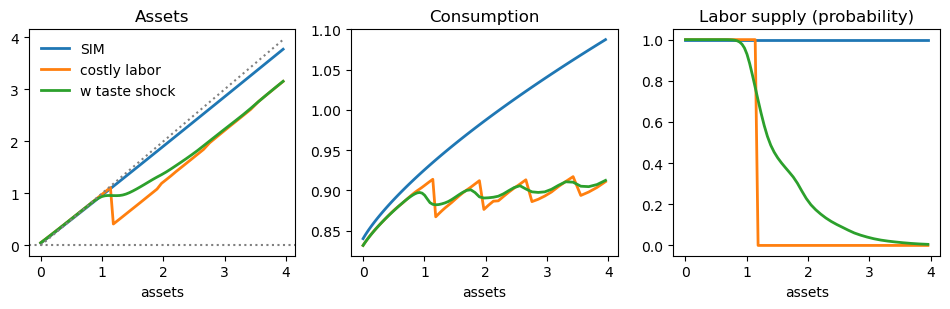

In [18]:
fig1(ss, amax=85, iz=3, figsize=0.8)

## 3 Adding search frictions

Let's tweak this model by adding search frictions. Let's assume that assume that households can choose employment only if they have an ongoing employment relationship (they were employed last period and have not lost their job) or have received a job offer (they were unemployed last period, and got an offer).

How to do this? All we have to do is introducing a new discrete shock stage.

In [19]:
search_stage = ExogenousMaker(markov_name='e_markov', index=0, name='search')

Write a hetinput function that builds the transition matrix for employment shocks.

In [20]:
def labor_lom(f, s):
    e_markov = np.array([[1 - s, s], [f, 1 - f]])
    return e_markov

We also have to modify to `labsup` stage to implements constraints on labor supply. We can implement this by saying that flow utility from choosing $n=1$ conditional on $n_{-} = 0$ is negative infinity.

In [21]:
def util_l_search(V, vphi):
    # on (n| n)
    flow_u = np.array([[-vphi, -np.inf],  # E|E and E|N
                       [0, 0]])           # N|E and N|N

    # on (n| n, z, a) grid
    shape = np.zeros((2, 2,) + V.shape[1:])
    flow_u = flow_u[..., np.newaxis, np.newaxis] + shape

    return flow_u

We're now ready to initialize the stage.

In [22]:
labsup_search_stage = LogitChoice(value='V', backward='Va', index=0, name='labsup_search',
                                  taste_shock_scale='taste_shock', f=util_l_search)

Build `StageBlock`.

In [23]:
hh2 = StageBlock([prod_stage, search_stage, labsup_search_stage, consav_stage], name='hh2',
                backward_init=hh_init, hetinputs=[make_grids, labor_income, labor_lom])

print(hh2)
print(f"Inputs: {hh2.inputs}")
print(f"Outputs: {hh2.outputs}")

<StageBlock 'hh2' with stages ['prod', 'search', 'labsup_search', 'consav']>
Inputs: ['taste_shock', 'vphi', 'r', 'beta', 'eis', 'rho_z', 'sd_z', 'n_z', 'min_a', 'max_a', 'n_a', 'w', 'f', 's']
Outputs: ['A', 'C', 'L']


Include job-finding and separation rates in calibration dicts.

In [24]:
for i in cali.keys():
    cali[i]['f'] = 0.6
    cali[i]['s'] = 0.1

In [25]:
for i in cali.keys():
    ss[i + '_search'] = hh2.steady_state(cali[i])

Plot labor supply functions only.

In [26]:
def fig2(ss, amax=150, iz=3, figsize=0.6):
    a_grid = ss['sim_search'].internals['hh2']['a_grid']
    P1 = ss['ck'].internals['hh']['labsup']['law_of_motion'].P
    P2 = ss['ck_search'].internals['hh2']['labsup_search']['law_of_motion'].P

    plt.plot(a_grid[:amax], P1[0, 0, iz, :amax], label='frictionless', linewidth=2)
    plt.plot(a_grid[:amax], P2[0, 0, iz, :amax], label='search friction', linewidth=2)
    plt.legend(frameon=False)
    plt.axhline(0, color='gray', linestyle=':')
    plt.title('Labor supply')
    plt.xlabel('assets')

    plt.tight_layout()
    plt.show()

Having a job is much more valuable in a world with search frictions.

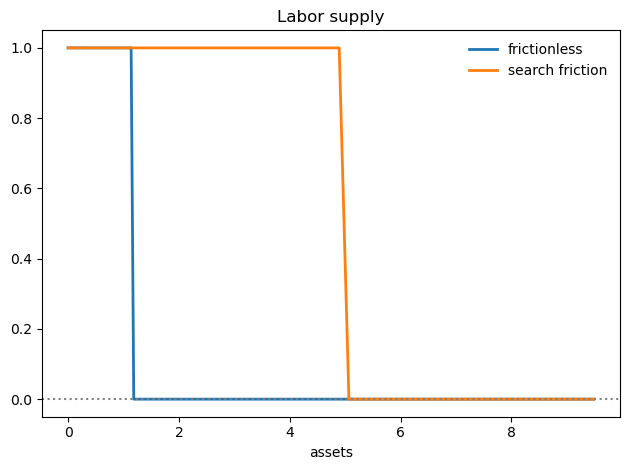

In [27]:
fig2(ss, 110)

### Jacobians

Disregard this warning. It's triggered by differentiating the discrete choice stage with `-np.inf` in flow utility. We'll turn of this warning in a future patch to the toolkit.

In [28]:
J = dict()
for i in ['sim', 'ck', 'ck_smooth']:
    J[i] = hh.jacobian(ss[i], ['r', 'w'], T=50)
    J[i + '_search'] = hh2.jacobian(ss[i  + '_search'], ['f', 's', 'r', 'w'], T=50)

/home/bbardoczy/Projects/sequence-jacobian-private/src/sequence_jacobian/utilities/function.py:118: RuntimeWarning: invalid value encountered in subtract


Search frictions significantly reduce intertemporal substitution in labor.

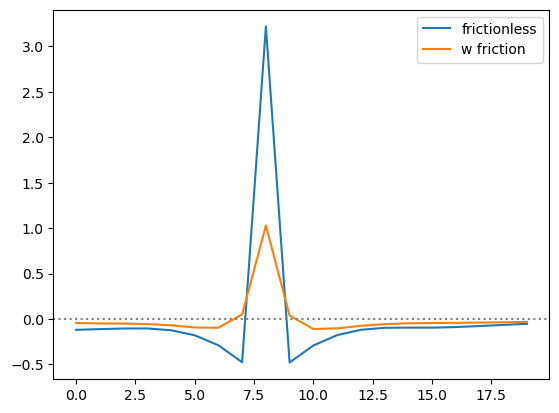

In [29]:
plt.plot(J['ck_smooth']['L']['w'][:20, 8], label='frictionless')
plt.plot(J['ck_smooth_search']['L']['w'][:20, 8], label='w friction')
plt.axhline(0, color='gray', linestyle=':')
plt.legend()
plt.show()